In [11]:
from netCDF4 import Dataset
import wrf
from wrf import getvar, ALL_TIMES, latlon_coords, CoordPair, vertcross, to_np, interpline
import xarray as xr
import numpy as np
import cartopy.crs as crs
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import matplotlib.cm as cm  
import matplotlib as mpl
import pandas as pd

In [8]:
# defining a WRF dataset for coordinates and urban outline
data_24_gr_4 = [Dataset('/g/data/li18/em3807_2/WRF_runs/NoUCM_GrUrban_2024_4/wrfout_d02_2024-02-10_21:00:00'),
Dataset('/g/data/li18/em3807_2/WRF_runs/NoUCM_GrUrban_2024_4/wrfout_d02_2024-02-10_22:00:00'),
Dataset('/g/data/li18/em3807_2/WRF_runs/NoUCM_GrUrban_2024_4/wrfout_d02_2024-02-11_21:10:00'),
Dataset('/g/data/li18/em3807_2/WRF_runs/NoUCM_GrUrban_2024_4/wrfout_d02_2024-02-12_21:10:00')]

# extracting SHI from radar data 
radar_2017_ter = xr.open_dataset('/g/data/rq0/level_2/71/SHI/71_20170218_shi.nc')
radar_2018_ter = xr.open_dataset('/g/data/rq0/level_2/71/SHI/71_20181220_shi.nc')
radar_2020_ter = xr.open_dataset('/g/data/rq0/level_2/71/SHI/71_20201217_shi.nc')
radar_2024_ter = xr.open_dataset('/g/data/rq0/level_2/71/SHI/71_20240213_shi.nc')

# maximising SHI over the storm day
max_2017_ter = radar_2017_ter.shi.max(['time'])
max_2018_ter = radar_2018_ter.shi.max(['time'])
max_2020_ter = radar_2020_ter.shi.max(['time'])
max_2024_ter = radar_2024_ter.shi.max(['time'])

In [9]:
# defining functions
def calc_mesh(shi):
    a = 2.54
    b = 0.5
    mesh = a*shi**b 
    return mesh

def gr_coastline():
    grland = wrf.getvar(data_24_gr_4, 'LU_INDEX', timeidx=8, method='cat')
    wat = np.where(grland != 17, 0, grland)
    water = np.where(wat == 17, 1, wat)
    water[0:290, 0:130] = 0 
    water[26:290, 0:156] = 0
    water[26:33, 0:157] = 0 
    water[25:30, 0:156] = 0
    water[47:49, 0:167] = 0
    water[80:160, 0:175] = 0
    water[95:160, 0:177] = 0
    water[120:190, 0:182] = 0
    water[132:190, 0:186] = 0
    water[150:154, 0:203] = 0
    water[168:172, 0:214] = 0
    water[190:210, 0:215] = 0
    water[192:200, 0:218] = 0
    water[210:290, 0:225] = 0
    water[220:290, 0:233] = 0
    water[225:290, 0:236] = 0
    water[230:290, 0:237] = 0
    water[232:290, 0:241] = 0
    water[229:290, 0:237] = 0
    water[242:290, 0:245] = 0
    water[251:290, 0:250] = 0
    water[278:290, 0:266] = 0
    return water


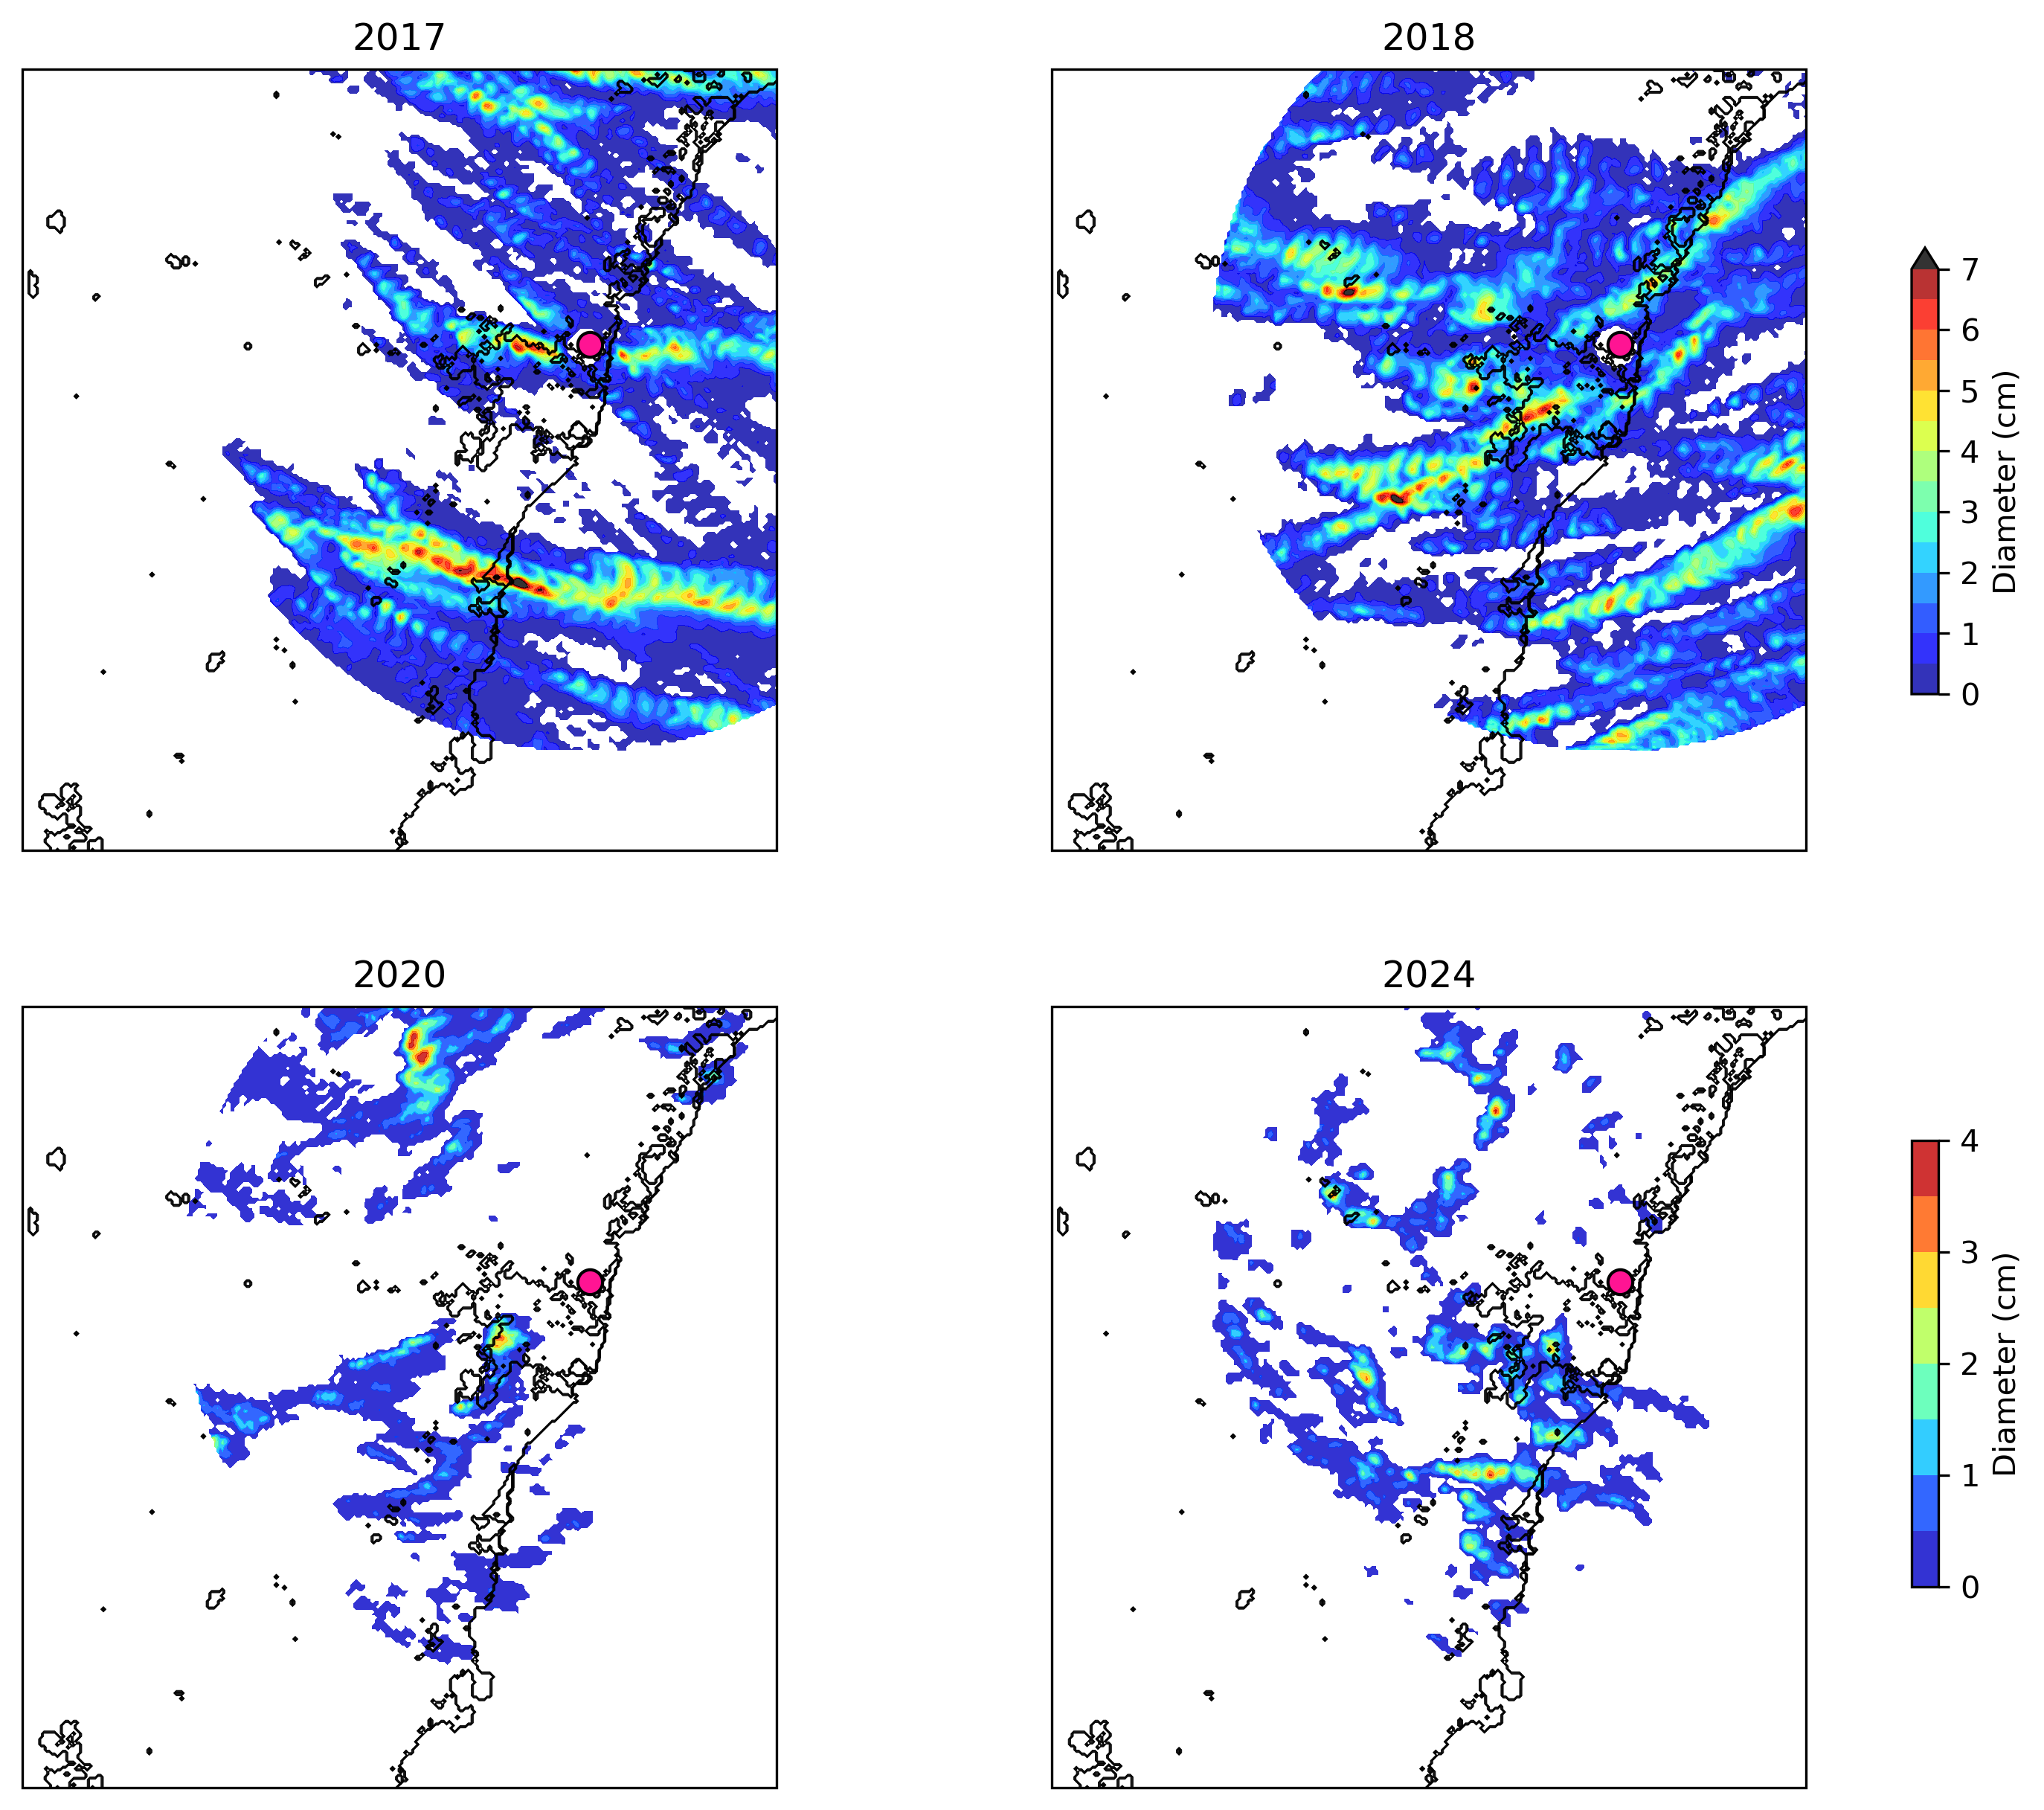

In [ ]:
# calculating MESH
hail_2017 = calc_mesh(max_2017_ter)
hail_2018 = calc_mesh(max_2018_ter)
hail_2020 = calc_mesh(max_2020_ter)
hail_2024 = calc_mesh(max_2024_ter)
hail_list = [hail_2017, hail_2018, hail_2020, hail_2024]

# defining the coordinates of the Terrey Hills radar
ter_lat = -33.6908
ter_lon = 151.2253

# for urban outline in WRF dataset
land = wrf.getvar(data_24_gr_4, 'LU_INDEX', timeidx=8, method='cat')
urb = np.where(land <= 49, 0, land) #set everything that isn't urban to zero
uniurb = np.where(urb >= 49, 1, urb) #make urban area uniform

cmapb = (mpl.colors.ListedColormap(['black']))
cmapb.set_bad(alpha=0)
bounds = [0,1]
norm = mpl.colors.BoundaryNorm(bounds, cmapb.N)

t_lats = radar_2017_ter['latitude']
t_lons = radar_2017_ter['longitude']

# defining the axes
lats2, lons2 = wrf.latlon_coords(land)
cart_proj = wrf.get_cartopy(land)
xy = cart_proj.transform_point(ter_lon, ter_lat, crs.PlateCarree())
fig, ax = plt.subplots(ncols=2,nrows=2, subplot_kw={'projection': cart_proj}, figsize=(12,10), dpi=300)
plt.subplots_adjust(wspace=0.2)

# setting levels for the contour plot
levels = np.linspace(0, 7, 15) 
levels2 = np.linspace(0, 4, 9) 

cmap = plt.get_cmap('jet').copy()
cmap.set_extremes(over='black')
axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]
titles = ['2017', '2018', '2020', '2024']

# plotting MESH plots
for a in axs:
    if a in axs[:2]:
        mesh_ter1 = a.contourf(wrf.to_np(t_lons), wrf.to_np(t_lats), wrf.to_np(hail_list[axs.index(a)])/10, 
                        transform=crs.PlateCarree(), cmap=cmap,levels= levels, extend = 'max', alpha = 0.8)
    else:
        mesh_ter2 = a.contourf(wrf.to_np(t_lons), wrf.to_np(t_lats), wrf.to_np(hail_list[axs.index(a)])/10, 
                transform=crs.PlateCarree(), cmap=cmap,levels= levels2, alpha = 0.8)
    a.contour(wrf.to_np(lons2), wrf.to_np(lats2), wrf.to_np(uniurb), 
                    transform=crs.PlateCarree(), cmap=cmapb, linewidths = 0.2) # plot after the colourmap is made
    a.contour(wrf.to_np(lons2), wrf.to_np(lats2), wrf.to_np(gr_coastline()), 
                    transform=crs.PlateCarree(), cmap=cmapb, linewidths = 0.2) 
    a.set_xlim(wrf.cartopy_xlim(land))
    a.set_ylim(wrf.cartopy_ylim(land))
    a.plot(xy[0], xy[1], marker='o', markersize=8, markerfacecolor='deeppink', markeredgecolor='black', markeredgewidth = 1)
    a.set_title(titles[axs.index(a)])

fig.subplots_adjust(right=0.83) # position of the right edge of the subplots
cbar_ax1 = fig.add_axes([0.85, 0.6, 0.01, 0.2]) #left, bottom, width, height

cbar_ax2 = fig.add_axes([0.85, 0.2, 0.01, 0.2]) #left, bottom, width, height

ticks = np.linspace(0,7,8)
ticks2 = np.linspace(0,4,5)
cbar = fig.colorbar(mesh_ter1, cax=cbar_ax1, ticks = ticks, extend = 'max')
cbar2 = fig.colorbar(mesh_ter2, cax=cbar_ax2, ticks = ticks2)
cbar.set_label("Diameter (cm)")
cbar2.set_label("Diameter (cm)")
